# Current Code

### hole_ratio_threshold = 0.01

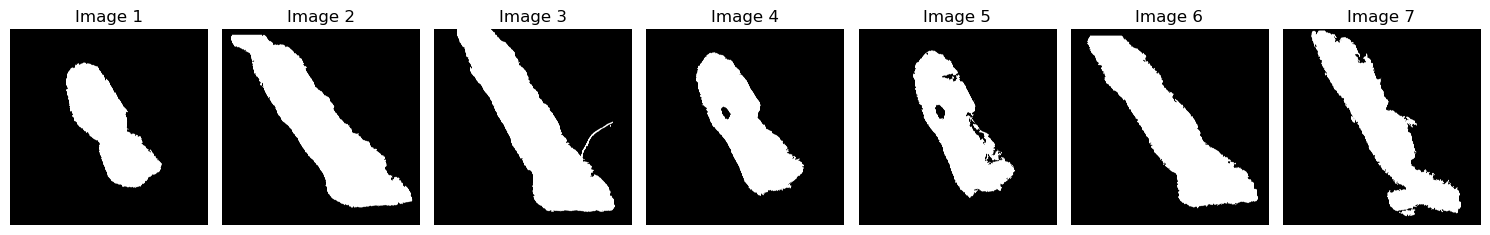

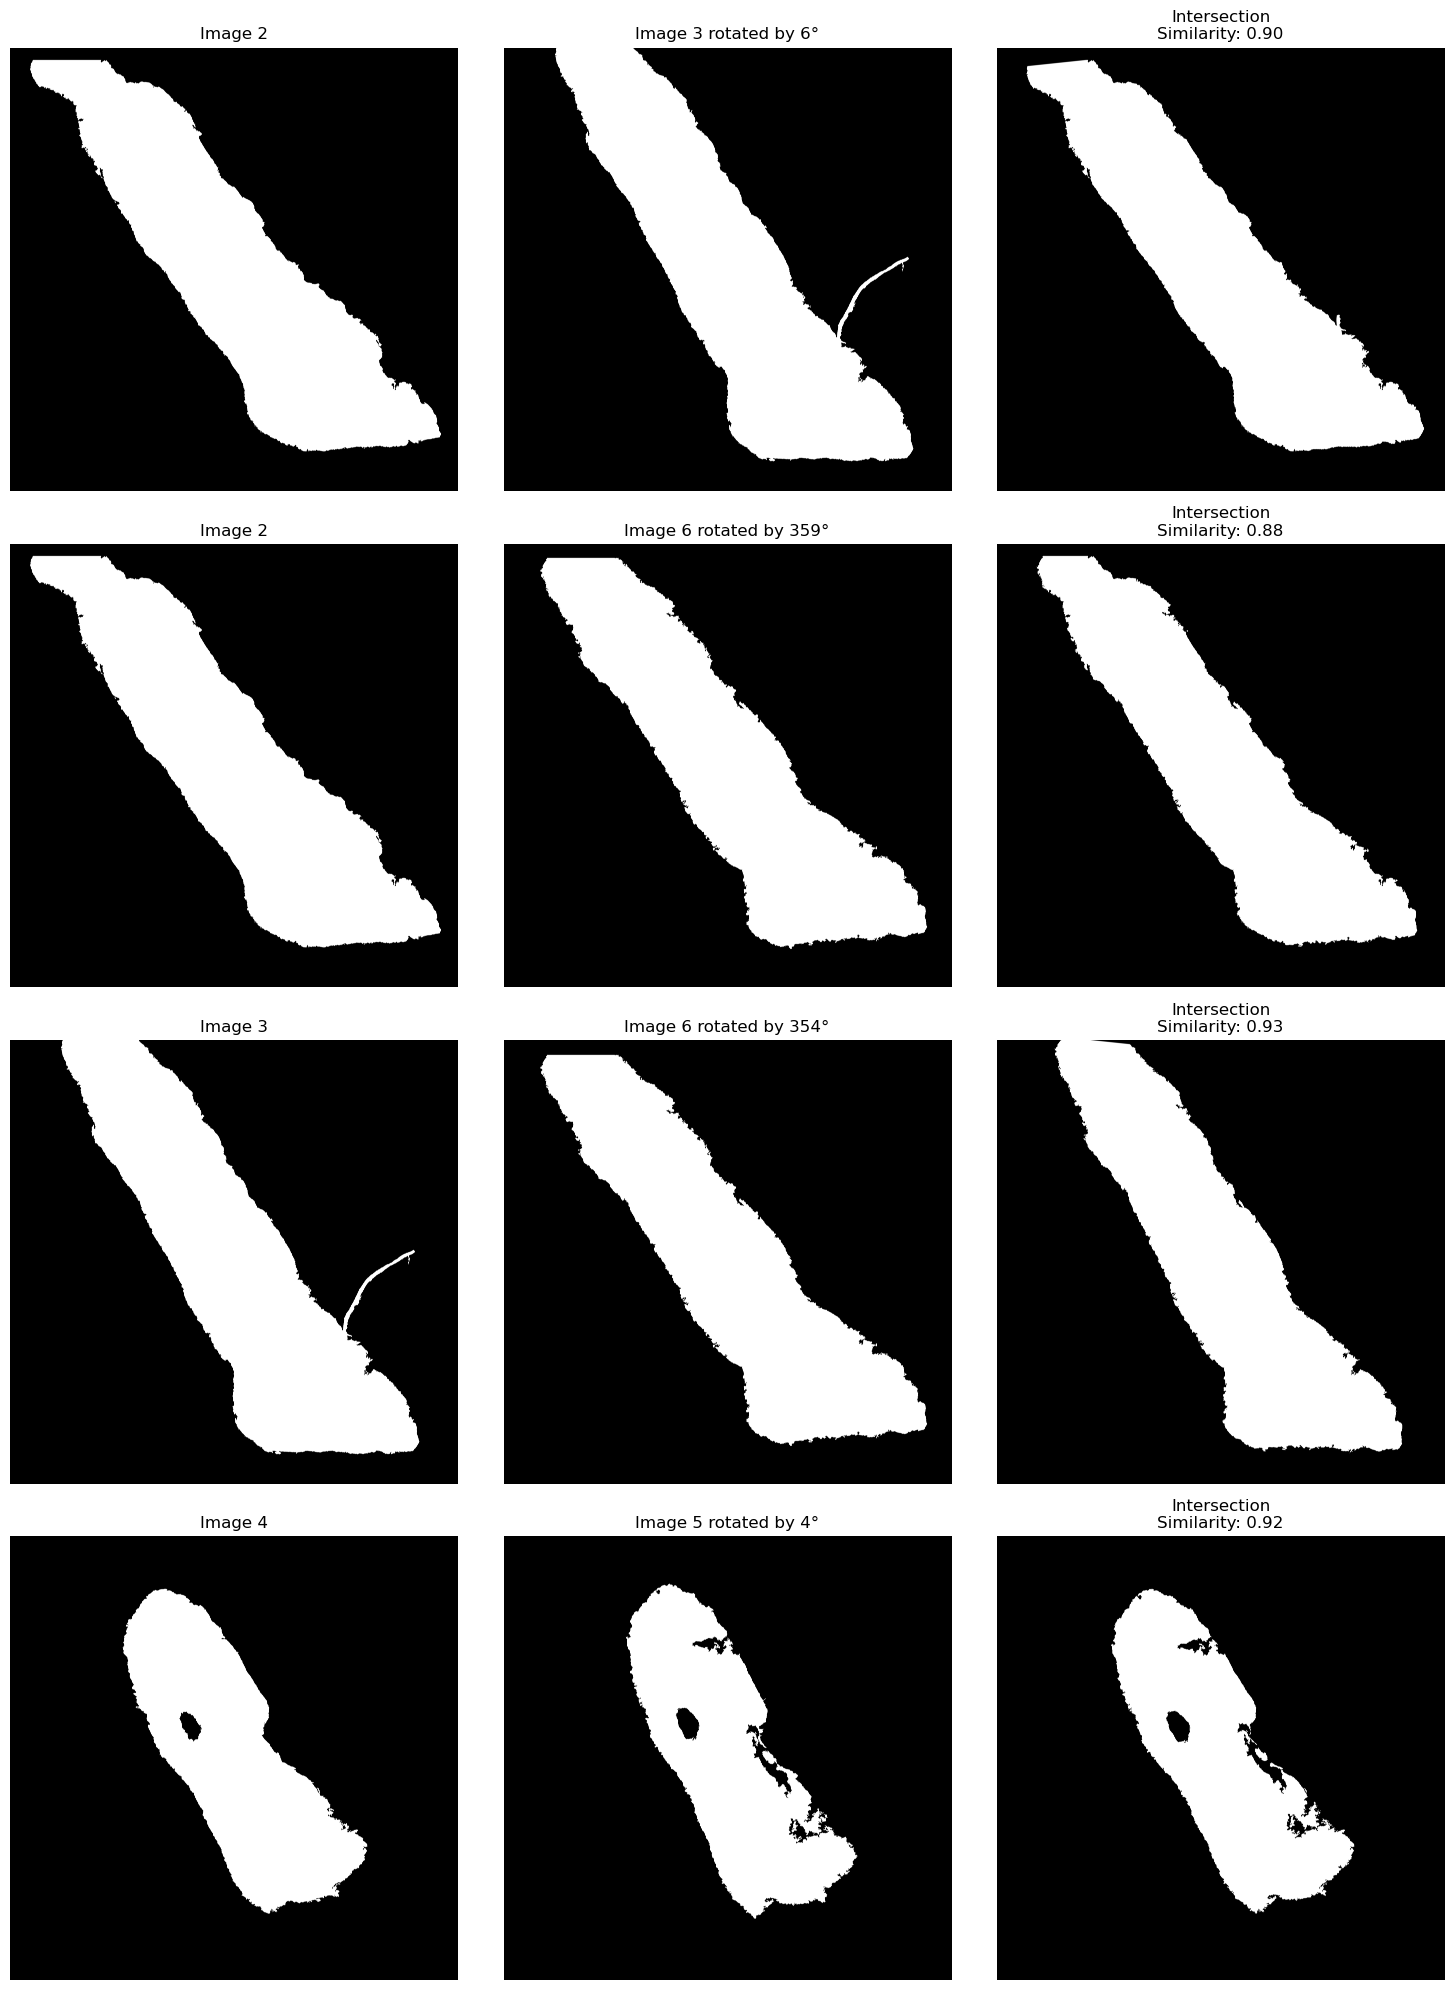

Similar image pairs:
Image 2 and Image 3 are similar with a score of 0.90 and a rotation angle of 6°
Image 2 and Image 6 are similar with a score of 0.88 and a rotation angle of 359°
Image 3 and Image 6 are similar with a score of 0.93 and a rotation angle of 354°
Image 4 and Image 5 are similar with a score of 0.92 and a rotation angle of 4°


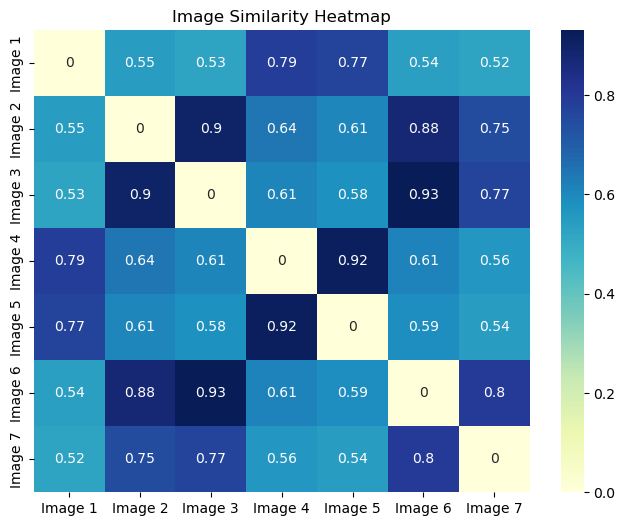

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# find and fill only the largest contour and subtract only significant holes
def fill_largest_contour_with_major_holes(img_shape, contours, hierarchy, hole_ratio_threshold=0.05):
    largest_contour_idx = None
    max_area = 0
    
    # find the index of the largest contour by area
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour_idx = i

    # if no contour found, return an empty mask
    if largest_contour_idx is None:
        return np.zeros(img_shape, dtype=np.uint8)

    mask = np.zeros(img_shape, dtype=np.uint8)
    largest_contour = contours[largest_contour_idx]

    # fill the largest contour
    if hierarchy[0][largest_contour_idx][3] == -1:  # Outer contour (no parent)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # define a dynamic hole area threshold based on a ratio of the largest contour's area
    dynamic_hole_threshold = max_area * hole_ratio_threshold
    
    # subtract only significant holes that are larger than the dynamic threshold
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == largest_contour_idx:  # if this contour is a hole (child of largest contour)
            hole_area = cv2.contourArea(contour)
            if hole_area > dynamic_hole_threshold:  # ignore holes smaller than the dynamic threshold
                cv2.drawContours(mask, [contour], -1, 0, thickness=cv2.FILLED)  # subtract the hole
    
    return mask

# calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# center the image based on the center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    return cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

# find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 1)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# load 5 images (or as many as needed, just remove comments and add image path)
images = [
    cv2.imread('Images/TIF/h2114155 h&e.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e2.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e3.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e4.tif', 0),
    cv2.imread('Images/TIF/h2114155 melan.tif', 0),
    cv2.imread('Images/TIF/h2114155 melan2.tif', 0),
    cv2.imread('Images/TIF/h2114155 sox10.tif', 0)  
]

# edge detection and contour processing for all images
processed_masks = []
for img in images:
    edges = cv2.Canny(img, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, hierarchy = cv2.findContours(cleaned_edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    mask = fill_largest_contour_with_major_holes(cleaned_edges.shape, contours, hierarchy, hole_ratio_threshold=0.01)
    centered_mask = center_image(mask)
    processed_masks.append(centered_mask)

# Get maximum width and height to resize all images
max_width = max(mask.shape[1] for mask in processed_masks)
max_height = max(mask.shape[0] for mask in processed_masks)

# Resize all masks to the same size with symmetrical padding
resized_masks = [pad_to_size(mask, (max_width, max_height)) for mask in processed_masks]

# Initialize similarity matrix for heatmap
similarity_matrix = np.zeros((len(resized_masks), len(resized_masks)))

# Compare all pairs of images
pair_scores = []
for (i, mask1), (j, mask2) in combinations(enumerate(resized_masks), 2):
    best_overlap, best_angle = find_best_rotation(mask1, mask2)
    rotated_mask2 = rotate_image(mask2, best_angle)
    intersection = cv2.bitwise_and(mask1, rotated_mask2)
    union = cv2.bitwise_or(mask1, rotated_mask2)
    final_similarity_score = np.sum(intersection) / np.sum(union)
    
    # Store similarity scores for heatmap
    similarity_matrix[i, j] = final_similarity_score
    similarity_matrix[j, i] = final_similarity_score
    
    pair_scores.append((i + 1, j + 1, final_similarity_score, best_angle, intersection))

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Filter pairs that are similar
similar_pairs = [pair for pair in pair_scores if pair[2] > similarity_threshold]

# Show all images in one row
fig, axes = plt.subplots(1, len(resized_masks), figsize=(15, 5))

# Display all input images
for idx, mask in enumerate(resized_masks):
    axes[idx].imshow(mask, cmap='gray')
    axes[idx].set_title(f"Image {idx + 1}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Visualize the results for similar comparisons only
if similar_pairs:
    num_similar = len(similar_pairs)
    fig, axes = plt.subplots(num_similar, 3, figsize=(15, num_similar * 5))

    # Handle case when only 1 pair is similar
    if num_similar == 1:
        axes = [axes]  # Wrap the 1D array in a list to make it 2D

    for idx, (i, j, score, angle, intersection) in enumerate(similar_pairs):
        # Original Images
        axes[idx][0].imshow(resized_masks[i - 1], cmap='gray')
        axes[idx][0].set_title(f"Image {i}")
        axes[idx][0].axis('off')

        axes[idx][1].imshow(resized_masks[j - 1], cmap='gray')
        axes[idx][1].set_title(f"Image {j} rotated by {angle}°")
        axes[idx][1].axis('off')

        # Intersection Image (only shown for similar images)
        axes[idx][2].imshow(intersection, cmap='gray')
        axes[idx][2].set_title(f"Intersection\nSimilarity: {score:.2f}")
        axes[idx][2].axis('off')

    plt.tight_layout()
    plt.show()

    # Display summary of similar pairs
    print("Similar image pairs:")
    for pair in similar_pairs:
        print(f"Image {pair[0]} and Image {pair[1]} are similar with a score of {pair[2]:.2f} and a rotation angle of {pair[3]}°")
else:
    print("No similar image pairs found.")

# Display heatmap for similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", xticklabels=[f"Image {i+1}" for i in range(len(images))], 
            yticklabels=[f"Image {i+1}" for i in range(len(images))])
plt.title("Image Similarity Heatmap")
plt.show()


### hole_ratio_threshold = 0.05

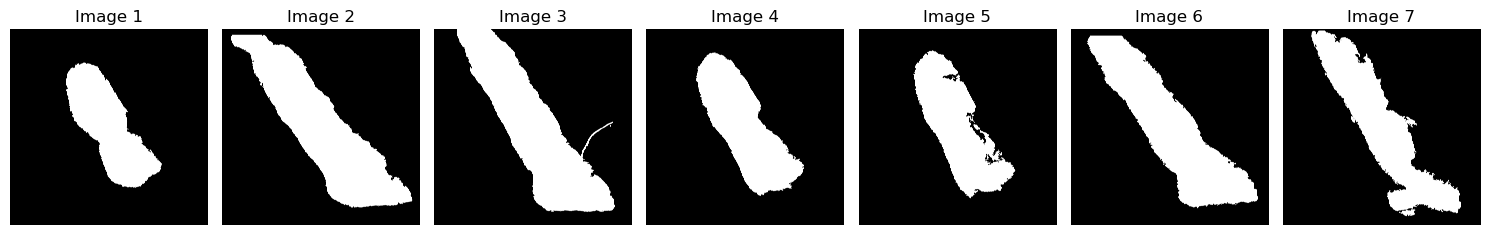

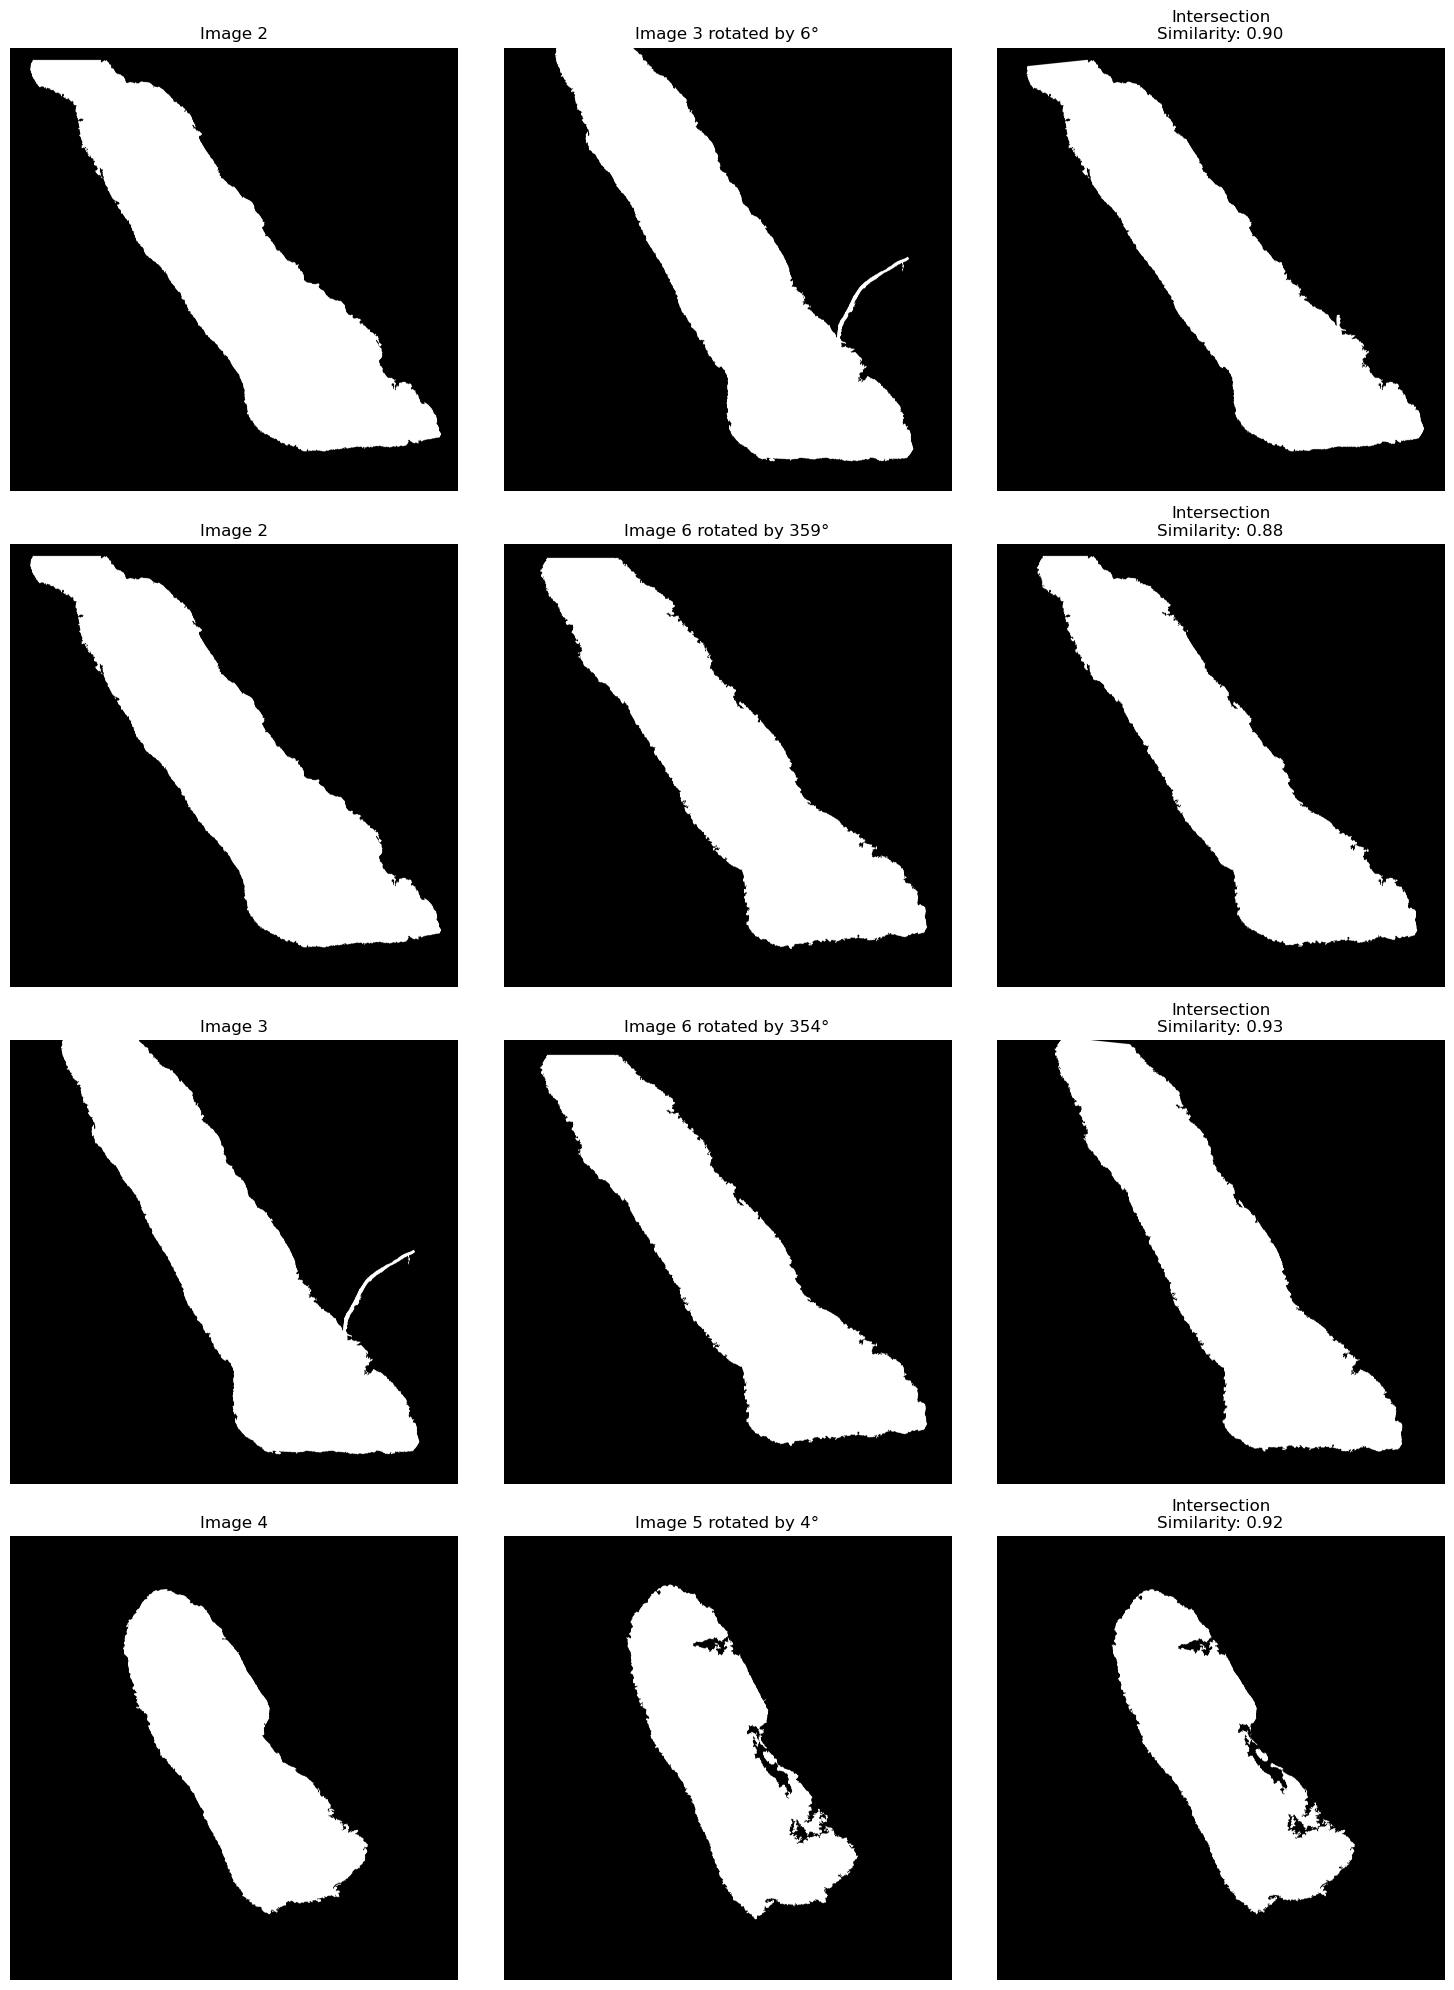

Similar image pairs:
Image 2 and Image 3 are similar with a score of 0.90 and a rotation angle of 6°
Image 2 and Image 6 are similar with a score of 0.88 and a rotation angle of 359°
Image 3 and Image 6 are similar with a score of 0.93 and a rotation angle of 354°
Image 4 and Image 5 are similar with a score of 0.92 and a rotation angle of 4°


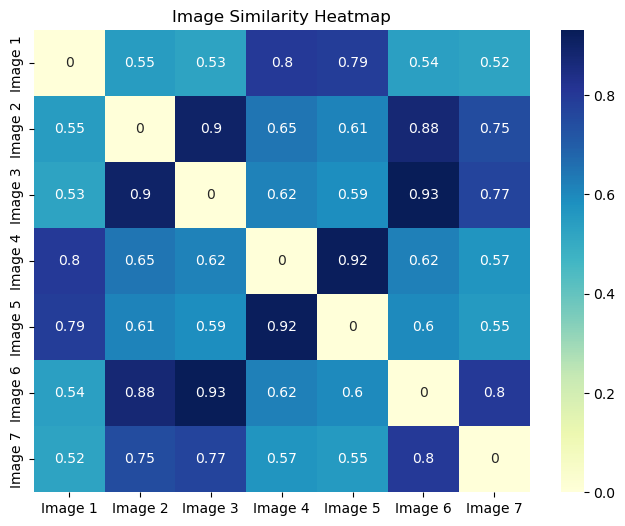

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# find and fill only the largest contour and subtract only significant holes
def fill_largest_contour_with_major_holes(img_shape, contours, hierarchy, hole_ratio_threshold=0.05):
    largest_contour_idx = None
    max_area = 0
    
    # find the index of the largest contour by area
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour_idx = i

    # if no contour found, return an empty mask
    if largest_contour_idx is None:
        return np.zeros(img_shape, dtype=np.uint8)

    mask = np.zeros(img_shape, dtype=np.uint8)
    largest_contour = contours[largest_contour_idx]

    # fill the largest contour
    if hierarchy[0][largest_contour_idx][3] == -1:  # Outer contour (no parent)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # define a dynamic hole area threshold based on a ratio of the largest contour's area
    dynamic_hole_threshold = max_area * hole_ratio_threshold
    
    # subtract only significant holes that are larger than the dynamic threshold
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == largest_contour_idx:  # if this contour is a hole (child of largest contour)
            hole_area = cv2.contourArea(contour)
            if hole_area > dynamic_hole_threshold:  # ignore holes smaller than the dynamic threshold
                cv2.drawContours(mask, [contour], -1, 0, thickness=cv2.FILLED)  # subtract the hole
    
    return mask

# calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# center the image based on the center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    return cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

# find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 1)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# load 5 images (or as many as needed, just remove comments and add image path)
images = [
    cv2.imread('Images/TIF/h2114155 h&e.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e2.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e3.tif', 0),
    cv2.imread('Images/TIF/h2114155 h&e4.tif', 0),
    cv2.imread('Images/TIF/h2114155 melan.tif', 0),
    cv2.imread('Images/TIF/h2114155 melan2.tif', 0),
    cv2.imread('Images/TIF/h2114155 sox10.tif', 0)  
]

# edge detection and contour processing for all images
processed_masks = []
for img in images:
    edges = cv2.Canny(img, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, hierarchy = cv2.findContours(cleaned_edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    mask = fill_largest_contour_with_major_holes(cleaned_edges.shape, contours, hierarchy, hole_ratio_threshold=0.05)
    centered_mask = center_image(mask)
    processed_masks.append(centered_mask)

# Get maximum width and height to resize all images
max_width = max(mask.shape[1] for mask in processed_masks)
max_height = max(mask.shape[0] for mask in processed_masks)

# Resize all masks to the same size with symmetrical padding
resized_masks = [pad_to_size(mask, (max_width, max_height)) for mask in processed_masks]

# Initialize similarity matrix for heatmap
similarity_matrix = np.zeros((len(resized_masks), len(resized_masks)))

# Compare all pairs of images
pair_scores = []
for (i, mask1), (j, mask2) in combinations(enumerate(resized_masks), 2):
    best_overlap, best_angle = find_best_rotation(mask1, mask2)
    rotated_mask2 = rotate_image(mask2, best_angle)
    intersection = cv2.bitwise_and(mask1, rotated_mask2)
    union = cv2.bitwise_or(mask1, rotated_mask2)
    final_similarity_score = np.sum(intersection) / np.sum(union)
    
    # Store similarity scores for heatmap
    similarity_matrix[i, j] = final_similarity_score
    similarity_matrix[j, i] = final_similarity_score
    
    pair_scores.append((i + 1, j + 1, final_similarity_score, best_angle, intersection))

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Filter pairs that are similar
similar_pairs = [pair for pair in pair_scores if pair[2] > similarity_threshold]

# Show all images in one row
fig, axes = plt.subplots(1, len(resized_masks), figsize=(15, 5))

# Display all input images
for idx, mask in enumerate(resized_masks):
    axes[idx].imshow(mask, cmap='gray')
    axes[idx].set_title(f"Image {idx + 1}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Visualize the results for similar comparisons only
if similar_pairs:
    num_similar = len(similar_pairs)
    fig, axes = plt.subplots(num_similar, 3, figsize=(15, num_similar * 5))

    # Handle case when only 1 pair is similar
    if num_similar == 1:
        axes = [axes]  # Wrap the 1D array in a list to make it 2D

    for idx, (i, j, score, angle, intersection) in enumerate(similar_pairs):
        # Original Images
        axes[idx][0].imshow(resized_masks[i - 1], cmap='gray')
        axes[idx][0].set_title(f"Image {i}")
        axes[idx][0].axis('off')

        axes[idx][1].imshow(resized_masks[j - 1], cmap='gray')
        axes[idx][1].set_title(f"Image {j} rotated by {angle}°")
        axes[idx][1].axis('off')

        # Intersection Image (only shown for similar images)
        axes[idx][2].imshow(intersection, cmap='gray')
        axes[idx][2].set_title(f"Intersection\nSimilarity: {score:.2f}")
        axes[idx][2].axis('off')

    plt.tight_layout()
    plt.show()

    # Display summary of similar pairs
    print("Similar image pairs:")
    for pair in similar_pairs:
        print(f"Image {pair[0]} and Image {pair[1]} are similar with a score of {pair[2]:.2f} and a rotation angle of {pair[3]}°")
else:
    print("No similar image pairs found.")

# Display heatmap for similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", xticklabels=[f"Image {i+1}" for i in range(len(images))], 
            yticklabels=[f"Image {i+1}" for i in range(len(images))])
plt.title("Image Similarity Heatmap")
plt.show()


# Baron's Code
- includes holes

Best rotation angle: 165°
The images are not similar enough. Final pixel overlap score: 0.7568840566694602


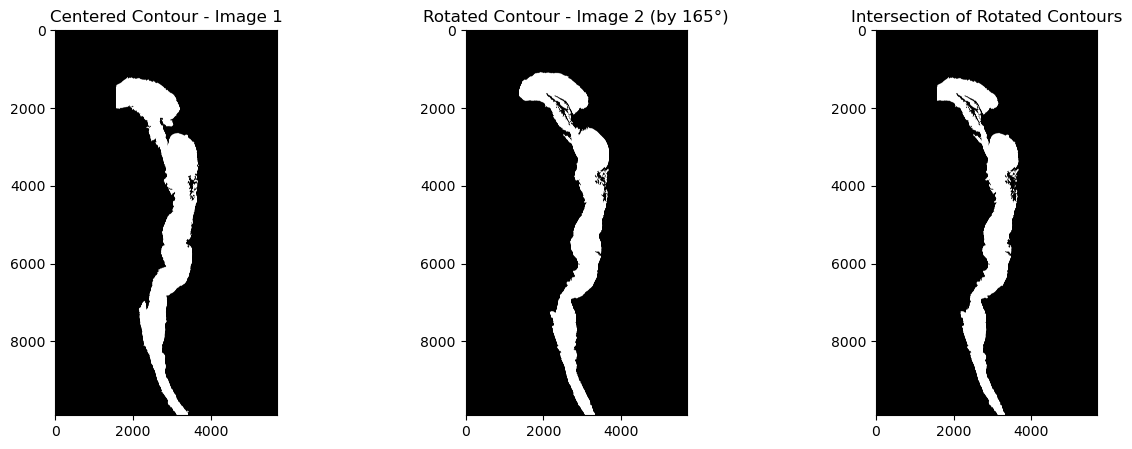

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# Find and fill only the largest contour and subtract only the largest hole
def fill_largest_contour_with_single_hole(img_shape, contours, hierarchy, hole_threshold=1000):
    largest_contour_idx = None
    max_area = 0
    
    # Find the index of the largest contour by area
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour_idx = i

    # If no contour found, return an empty mask
    if largest_contour_idx is None:
        return np.zeros(img_shape, dtype=np.uint8)

    mask = np.zeros(img_shape, dtype=np.uint8)
    largest_contour = contours[largest_contour_idx]

    # Fill the largest contour
    if hierarchy[0][largest_contour_idx][3] == -1:  # Outer contour (no parent)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    # Now subtract only the largest hole (ignore small gaps)
    largest_hole_area = 0
    largest_hole_idx = -1
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == largest_contour_idx:  # If this contour is a hole (child of largest contour)
            hole_area = cv2.contourArea(contour)
            if hole_area > largest_hole_area and hole_area > hole_threshold:  # Threshold to ignore small holes
                largest_hole_area = hole_area
                largest_hole_idx = i
    
    # Subtract the largest hole if found
    if largest_hole_idx != -1:
        cv2.drawContours(mask, [contours[largest_hole_idx]], -1, 0, thickness=cv2.FILLED)  # Subtract the hole
    
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on the center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    return cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

# Find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(0, 360, 1)):
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

# Load the images (Ensure to use your .tif files)
#img1 = cv2.imread('Images/TIF/h2114155 melan.tif', 0)
#img2 = cv2.imread('Images/TIF/h2114155 h&e.tif', 0)
#img1 = cv2.imread('Images/TIF/h2114157sox10.tif', 0)
#img2 = cv2.imread('Images/TIF/h2114157h&e.tif', 0)
img1 = cv2.imread('Images/TIF/h2114158h&e2.tif', 0)
img2 = cv2.imread('Images/TIF/h2114158melan.tif', 0)


# Edge Detection using Canny
edges1 = cv2.Canny(img1, 50, 100)
edges2 = cv2.Canny(img2, 50, 100)

# Clean the edges
cleaned_edges1 = clean_edges(edges1)
cleaned_edges2 = clean_edges(edges2)

# Find contours using cv2.RETR_CCOMP to detect both outer and inner contours
contours1, hierarchy1 = cv2.findContours(cleaned_edges1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours2, hierarchy2 = cv2.findContours(cleaned_edges2, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Create masks by filling the largest contour including only the largest hole
mask1 = fill_largest_contour_with_single_hole(cleaned_edges1.shape, contours1, hierarchy1, hole_threshold=1000)
mask2 = fill_largest_contour_with_single_hole(cleaned_edges2.shape, contours2, hierarchy2, hole_threshold=1000)

# Center the filled masks
centered_mask1 = center_image(mask1)
centered_mask2 = center_image(mask2)

# Get maximum width and height to resize both images
max_width = max(centered_mask1.shape[1], centered_mask2.shape[1])
max_height = max(centered_mask1.shape[0], centered_mask2.shape[0])

# Resize both masks to the same size with symmetrical padding
centered_mask1 = pad_to_size(centered_mask1, (max_width, max_height))
centered_mask2 = pad_to_size(centered_mask2, (max_width, max_height))

# Find the best rotation for mask2 that maximizes overlap with mask1
best_overlap, best_angle = find_best_rotation(centered_mask1, centered_mask2)

# Rotate mask2 by the best angle
rotated_mask2 = rotate_image(centered_mask2, best_angle)

# Compare the final masks pixel-wise
intersection = cv2.bitwise_and(centered_mask1, rotated_mask2)
union = cv2.bitwise_or(centered_mask1, rotated_mask2)
final_similarity_score = np.sum(intersection) / np.sum(union)

# Set a threshold for similarity
similarity_threshold = 0.8  # Adjust this threshold as needed

# Print the best angle, similarity score, and decision
print(f"Best rotation angle: {best_angle}°")
if final_similarity_score > similarity_threshold:
    print(f"The images are similar. Final pixel overlap score: {final_similarity_score}")
else:
    print(f"The images are not similar enough. Final pixel overlap score: {final_similarity_score}")

# Display the masks and comparison result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Centered Contour - Image 1')
plt.imshow(centered_mask1, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Rotated Contour - Image 2 (by {best_angle}°)')
plt.imshow(rotated_mask2, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Intersection of Rotated Contours')
plt.imshow(intersection, cmap='gray')

plt.show()